---
# <span style='color:#1B127A;'> Setup </span>

In [1]:
import rmsp
rmsp.activate()
rmsp.support()

License 080ebbe4103361ec checked out by hadavand@resmodsol.com to f087b30fe8f0d8d6 expires in 30 minutes. RMSP version 1.8.12 is out of date. There is a new version 1.10.1 featuring smooth univariate and multivariate transformers, isosurfaces for generating meshes from grids, and major speedups to subgrid from solid generation, as well as a number of other optimizations, improvements, and fixes! Visit https://portal.resourcemodelingsolutions.com to download the updated version. After upgrading this message may not update immediately.

Python and RMSP Versions Support Information:
 - python version: sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
 - rmsp version: 1.8.12
 - numpy version: 1.21.5
 - pandas version: 1.3.4
 - matplotlib version: 3.1.3
 - platform: Windows-10-10.0.19041-SP0

For documentation and self service assistance please visit https://portal.resourcemodelingsolutions.com
For additional support please contact Resource Modeling Solutions at su

In [7]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys, os
%load_ext autoreload
%autoreload 2

## <span style='color:#5177F9;'> Setup Data</span>

In [8]:
data = rmsp.PointData(
    {
        "DHID": [1, 2, 3, 4, 5, 6, 7],
        "X": [61, 63, 64, 68, 71, 73, 75],
        "Y": [139, 140, 129, 128, 140, 141, 128],
        "Z": [0, 0, 0, 0, 0, 0, 0],
        "V": [477, 696, 227, 646, 606, 791, 783]
    }, x='X', y='Y', z='Z', dhid='DHID'
)
data.head()

,DHID,X,Y,Z,V
0,1,61.0,139.0,0.0,477
1,2,63.0,140.0,0.0,696
2,3,64.0,129.0,0.0,227
3,4,68.0,128.0,0.0,646
4,5,71.0,140.0,0.0,606


In [9]:
location = rmsp.PointData(
    {
        "DHID": [0],
        "X": [65],
        "Y": [137],
        "Z": [0],
    }, x='X', y='Y', z='Z', dhid='DHID'
)

---
# <span style='color:#1B127A;'>Estimate </span>

## <span style='color:#5177F9;'> OK </span>

In [13]:
varstr = """1    0.0                         -nst, nugget effect
            2    10  0.0   0.0   0.0        -it,cc,ang1,ang2,ang3
            10.0  10.0  10.0            -a_hmax, a_hmin, a_vert"""
variomodel = rmsp.VarioModel(vario_str=varstr)
variomodel.to_table()

,Nugget,Structure 1
Contribution,0.000,10.000
Model Shape,,exponential
Angle 1,,0.0
Angle 2,,0.0
Angle 3,,0.0
Range 1,,10.0
Range 2,,10.0
Range 3,,10.0


In [17]:
ok_est = rmsp.KrigeEstimator(
    ktype="ok",
    search=rmsp.Search(ranges=[100] * 3, min_comps=1, max_comps=20),
    vario=variomodel,
)

In [31]:
ok_est.estimate(
    location, data, "V", output=["estimate", "estimate_var"], accumulate_weights=True
)

,DHID,X,Y,Z,estimate,estimate_var
0,0,65.0,137.0,0.0,592.728943,8.956053


In [33]:
ok_est.get_cumulative_weights()

0    0.172937
1    0.317794
2    0.128734
3    0.086397
4    0.151128
5    0.057235
6    0.085776
dtype: float64

### <span style='color:#51AFF9;'> Scaling variogram </span>

Note that this is the scaling of the variogram and not the continuity ranges.

$\gamma_2 = 2\times \gamma_1$

Therefore, its effect is just focused on increasing the stationary variance.

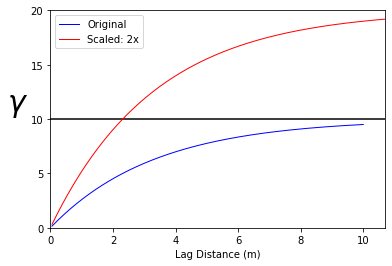

In [28]:
varstr_scaled = """1    0.0                         -nst, nugget effect
            2    20  0.0   0.0   0.0        -it,cc,ang1,ang2,ang3
            10.0  10.0  10.0            -a_hmax, a_hmin, a_vert"""
variomodel_scaled = rmsp.VarioModel(vario_str=varstr_scaled)
fig,ax = variomodel.plot(c='b', label='Original', ylim=[0,20], sill=None)
variomodel_scaled.plot_draw(ax, c='r', label='Scaled: 2x')
ax.legend()

Rescaling the variogram values has not affected the ordinary kriging weights or the ordinary kriging estimate; however, it has affected the ordinary kriging variance. These effects will be observed with any rescaling; while the estimate itself is unchanged, the estimation variance increases by the same factor that was used to scale the variogram

In [35]:
ok_est_scale = rmsp.KrigeEstimator(
    ktype="ok",
    search=rmsp.Search(ranges=[100] * 3, min_comps=1, max_comps=20),
    vario=variomodel_scaled,
)
ok_est_scale.estimate(location, data, 'V',output=['estimate', 'estimate_var'], accumulate_weights=True)

,DHID,X,Y,Z,estimate,estimate_var
0,0,65.0,137.0,0.0,592.728943,17.912106


In [36]:
ok_est_scale.get_cumulative_weights()

0    0.172937
1    0.317794
2    0.128734
3    0.086397
4    0.151128
5    0.057235
6    0.085776
dtype: float64